In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
wa = df[df.state == 'Washington']
wa = wa[wa.date >= '2020-03-15']
tn = df[df.state == 'Tennessee']
tn = tn[tn.date >= '2020-03-15']
ut = df[df.state == 'Utah']
ut = ut[ut.date >= '2020-03-15']
ny = df[df.state == 'New York']
ny = ny[ny.date >= '2020-03-15']
us = df[df.date >= '2020-03-15']

In [3]:
wa = wa.groupby('date').sum()
wa_last = wa.shift(periods=1)
wa['last_cases'] = wa_last.cases
wa['last_deaths'] = wa_last.deaths
wa['daily_cases'] = wa.cases - wa.last_cases
wa['daily_deaths'] = wa.deaths - wa.last_deaths
wa = wa.reset_index()

us = us.groupby('date').sum()
us_last = us.shift(periods=1)
us['last_cases'] = us_last.cases
us['last_deaths'] = us_last.deaths
us['daily_cases'] = us.cases - us.last_cases
us['daily_deaths'] = us.deaths - us.last_deaths
us = us.reset_index()

ut = ut.groupby('date').sum()
ut_last = ut.shift(periods=1)
ut['last_cases'] = ut_last.cases
ut['last_deaths'] = ut_last.deaths
ut['daily_cases'] = ut.cases - ut.last_cases
ut['daily_deaths'] = ut.deaths - ut.last_deaths
ut = ut.reset_index()

ny = ny.groupby('date').sum()
ny_last = ny.shift(periods=1)
ny['last_cases'] = ny_last.cases
ny['last_deaths'] = ny_last.deaths
ny['daily_cases'] = ny.cases - ny.last_cases
ny['daily_deaths'] = ny.deaths - ny.last_deaths
ny = ny.reset_index()

tn = tn.groupby('date').sum()
tn_last = tn.shift(periods=1)
tn['last_cases'] = tn_last.cases
tn['last_deaths'] = tn_last.deaths
tn['daily_cases'] = tn.cases - tn.last_cases
tn['daily_deaths'] = tn.deaths - tn.last_deaths
tn = tn.reset_index()

In [9]:
print('Utah')
print(ut.tail(10))
print('Tennessee')
print(tn.tail(10))
print('Washington')
print(wa.tail(10))
print('New York')
print(ny.tail(10))
print('US')
print(us.tail(10))

Utah
          date       fips  cases  deaths  last_cases  last_deaths  \
26  2020-04-10  1029603.0   2103      17      1980.0         13.0   
27  2020-04-11  1078632.0   2221      18      2103.0         17.0   
28  2020-04-12  1078632.0   2303      18      2221.0         18.0   
29  2020-04-13  1078632.0   2399      18      2303.0         18.0   
30  2020-04-14  1078632.0   2418      19      2399.0         18.0   
31  2020-04-15  1127673.0   2549      20      2418.0         19.0   
32  2020-04-16  1127673.0   2683      21      2549.0         20.0   
33  2020-04-17  1127673.0   2813      23      2683.0         21.0   
34  2020-04-18  1176712.0   2942      25      2813.0         23.0   
35  2020-04-19  1176712.0   3071      27      2942.0         25.0   

    daily_cases  daily_deaths  
26        123.0           4.0  
27        118.0           1.0  
28         82.0           0.0  
29         96.0           0.0  
30         19.0           1.0  
31        131.0           1.0  
32        1

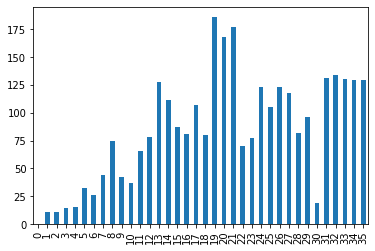

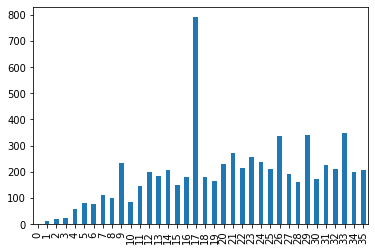

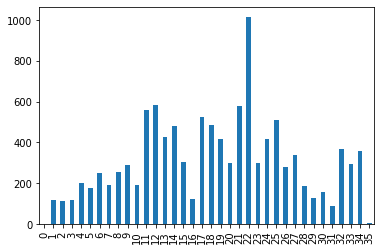

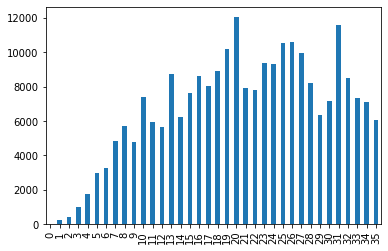

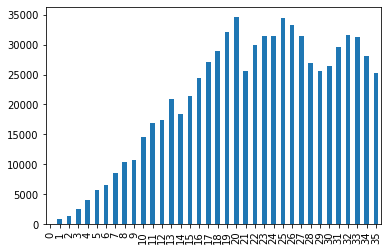

In [10]:
ut.daily_cases.plot(kind='bar')
plt.show()

tn.daily_cases.plot(kind='bar')
plt.show()

wa.daily_cases.plot(kind='bar')
plt.show()

ny.daily_cases.plot(kind='bar')
plt.show()

us.daily_cases.plot(kind='bar')
plt.show()

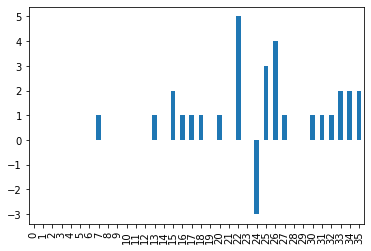

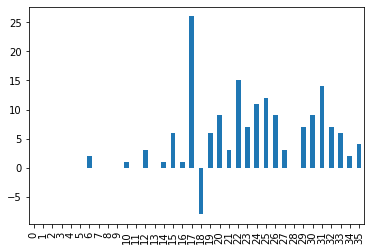

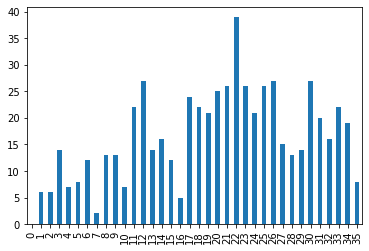

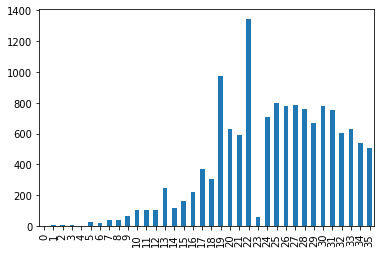

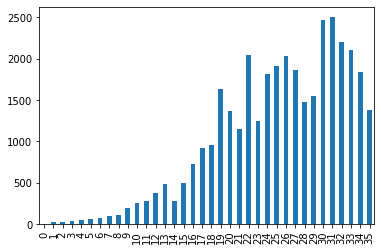

In [6]:
ut.daily_deaths.plot(kind='bar')
plt.show()

tn.daily_deaths.plot(kind='bar')
plt.show()

wa.daily_deaths.plot(kind='bar')
plt.show()

ny.daily_deaths.plot(kind='bar')
plt.show()

us.daily_deaths.plot(kind='bar')
plt.show()